## **CIFAR-10 Image Classification**

This notebook demonstrates a complete, human-friendly CIFAR-10 pipeline using TensorFlow / Keras.

What you'll find here:
- Data loading and friendly visual exploration
- Clean preprocessing and optional augmentation
- A robust CNN with BatchNorm & Dropout
- Training with callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
- Saving models + class mapping
- Single-image prediction helper (for UI/API)
- Retraining helper that continues training from the latest model (versioned backups)
- Full evaluation: Accuracy, Precision, Recall, F1, Confusion Matrix
- All important artifacts saved under `models/` and `logs/` for submission

## **Imports and Setup**

In [1]:
# Imports and environment setup
import os
import json
import shutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Reproducibility seeds
np.random.seed(42)
tf.random.set_seed(42)

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data/retrain', exist_ok=True)  # new images for retraining go here

# Plot style
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

## **1. Load CIFAR-10 dataset**

CIFAR-10 includes 50,000 training images and 10,000 test images in 10 classes.
Loaded the dataset from Keras, print shapes, and set class names.

In [2]:
print("Loading CIFAR-10 dataset...")
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

print(f"Train images: {X_train.shape}, Train labels: {y_train.shape}")
print(f"Test images : {X_test.shape}, Test labels : {y_test.shape}")

Loading CIFAR-10 dataset...
Train images: (50000, 32, 32, 3), Train labels: (50000, 1)
Test images : (10000, 32, 32, 3), Test labels : (10000, 1)


## **2. Exploratory Data Analysis (EDA)**
I'll:
- Show one sample image per class
- Plot the class distribution for the train and test sets
- Show a sample pixel intensity histogram

These help us understand dataset balance and pixel statistics.

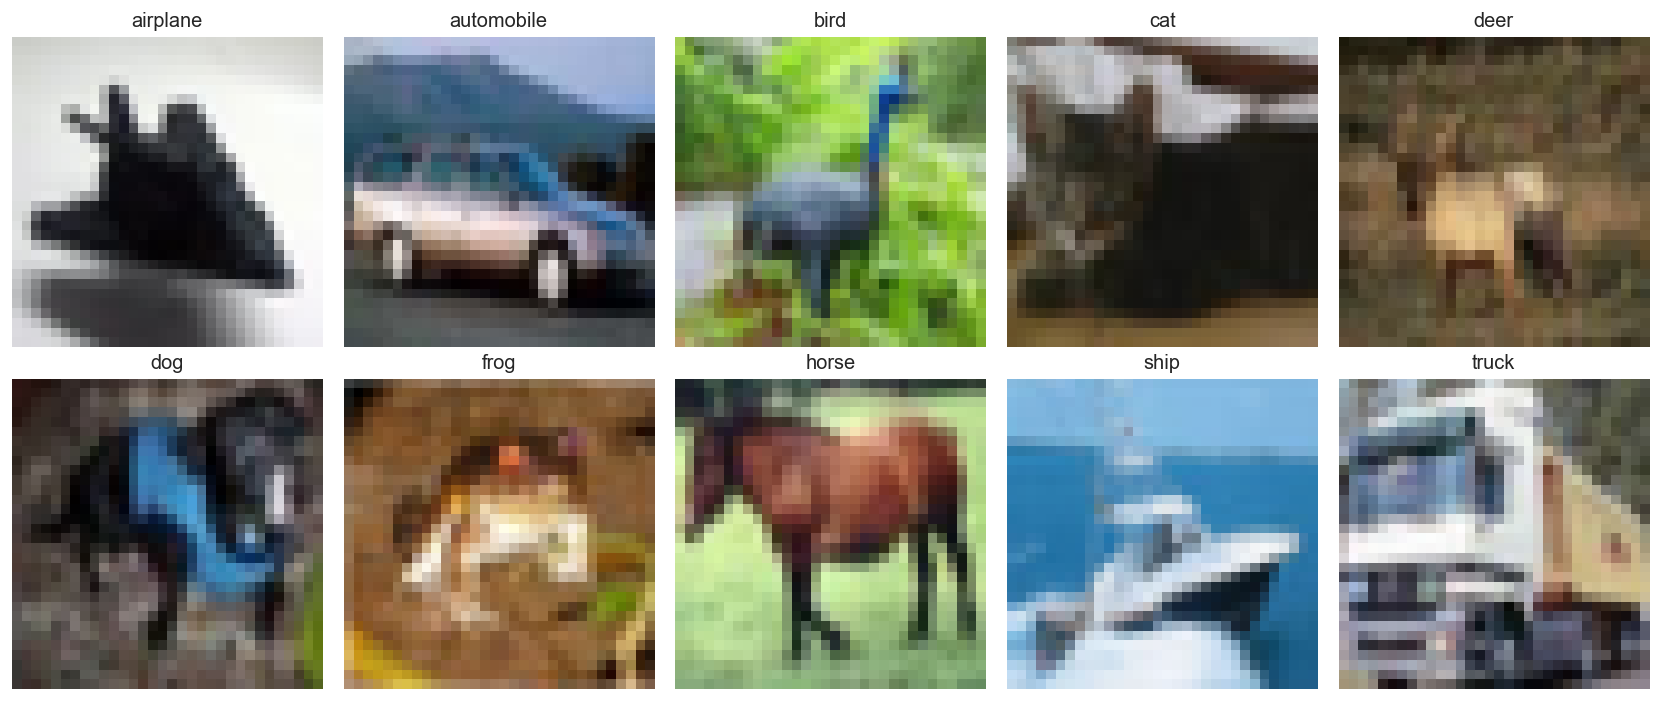

In [4]:
# Sample image per class
plt.figure(figsize=(14,6))
for i in range(10):
    idx = np.where(y_train.reshape(-1) == i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('logs/sample_images.png', bbox_inches='tight', dpi=150)
plt.show()

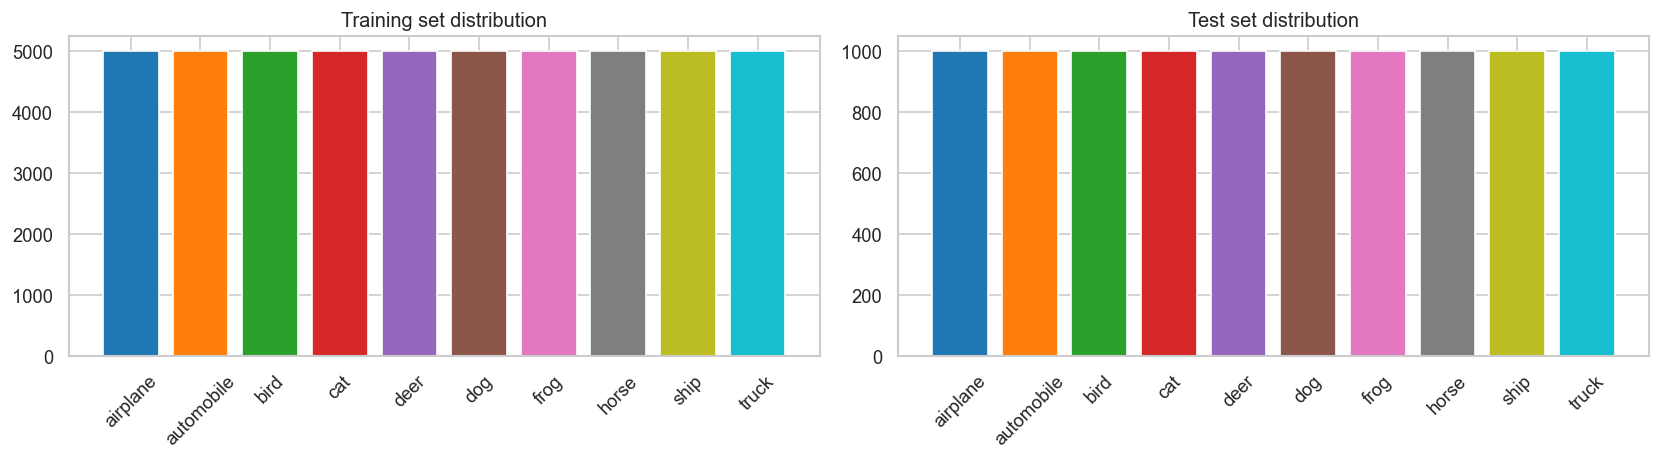

In [5]:
# Class distributions
fig, axs = plt.subplots(1,2, figsize=(14,4))
unique, counts = np.unique(y_train, return_counts=True)
axs[0].bar(range(10), counts, color=sns.color_palette("tab10"))
axs[0].set_xticks(range(10)); axs[0].set_xticklabels(class_names, rotation=45)
axs[0].set_title('Training set distribution')

unique_t, counts_t = np.unique(y_test, return_counts=True)
axs[1].bar(range(10), counts_t, color=sns.color_palette("tab10"))
axs[1].set_xticks(range(10)); axs[1].set_xticklabels(class_names, rotation=45)
axs[1].set_title('Test set distribution')

plt.tight_layout()
plt.savefig('logs/class_distribution.png', dpi=150)
plt.show()

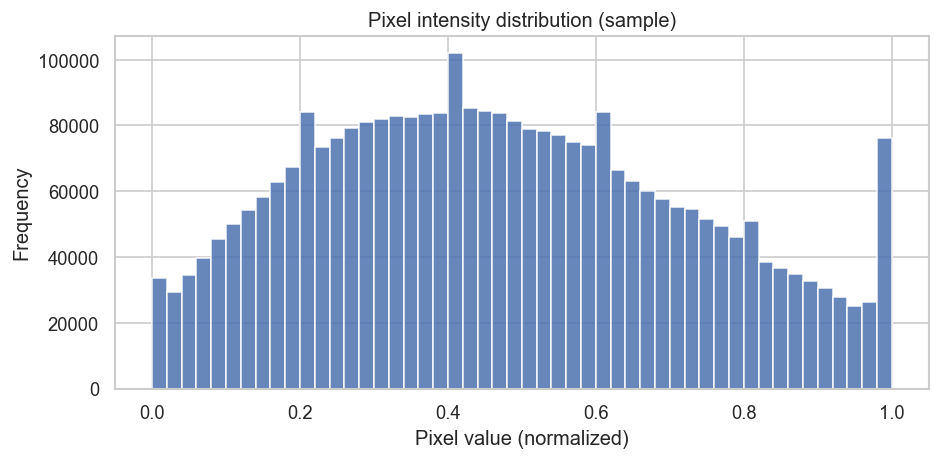

In [6]:
# Pixel intensity histogram (sample)
sample_flat = X_train[:1000].astype('float32').reshape(-1) / 255.0
plt.figure(figsize=(8,4))
plt.hist(sample_flat, bins=50, alpha=0.85, color='#4C72B0')
plt.title('Pixel intensity distribution (sample)')
plt.xlabel('Pixel value (normalized)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('logs/pixel_distribution.png', dpi=150)
plt.show()

## **3. Preprocessing & augmentation**

- Normalized pixel values to [0,1]. This makes training stable and faster.
- One-hot encode labels for the softmax output.
- Provided a gentle augmentation pipeline (horizontal flip, small rotation, zoom). Use augmentation moderately. It helps generalization.

In [8]:
NUM_CLASSES = 10
IMG_SHAPE = (32,32,3)

def preprocess_arrays(X, y):
    Xp = X.astype('float32') / 255.0
    yp = to_categorical(y, NUM_CLASSES)
    return Xp, yp

# Data augmentation layers (applied only during training)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.06),
], name="data_augmentation")

# Apply preprocess
X_train_p, y_train_p = preprocess_arrays(X_train, y_train)
X_test_p, y_test_p = preprocess_arrays(X_test, y_test)

print("Preprocessing done. Train shape:", X_train_p.shape)

Preprocessing done. Train shape: (50000, 32, 32, 3)


## **4. Model architecture**
- Used three convolutional blocks with BatchNormalization and Dropout.
- BatchNormalization helps training stability; Dropout prevents overfitting.
- The model is intentionally moderate in size, so it trains in a modest time on typical student hardware.
- The augmentation layer is included in the model so we get consistent behavior during `model.fit`.

In [9]:
def create_cnn_model(input_shape=IMG_SHAPE, num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # Block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    # Block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    # Block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    # Dense head
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='cifar10_cnn')
    return model

model = create_cnn_model()
model.summary()

Model: "cifar10_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │              

 Total params: 404,778 (1.54 MB)

 Trainable params: 403,882 (1.54 MB)

 Non-trainable params: 896 (3.50 KB)

## **5. Compile & training plan**
Compiled with Adam and categorical crossentropy.
Training strategy:
- Batch size: 128 (fits my machine)
- Epochs: 20 (EarlyStopping with patience=3 will stop earlier before overfitting)
- Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
Saved both a timestamped model and a `latest` copy for easy API loading.

In [11]:
# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks and paths
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_path = f"models/cifar10_model_best_{timestamp}.h5"
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

BATCH_SIZE = 128
EPOCHS = 20

print("Starting training...")
history = model.fit(
    X_train_p, y_train_p,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Save models
final_model_path = f"models/cifar10_model_{timestamp}.h5"
model.save(final_model_path)
latest_path = "models/cifar10_model_latest.h5"
model.save(latest_path)
print(f"Saved final model: {final_model_path}")
print(f"Saved latest model: {latest_path}")

Starting training...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.2885 - loss: 2.3036
Epoch 1: val_loss improved from None to 2.60469, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 115s 327ms/step - accuracy: 0.3552 - loss: 1.9373 - val_accuracy: 0.1741 - val_loss: 2.6047 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4685 - loss: 1.4747
Epoch 2: val_loss improved from 2.60469 to 1.43103, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 286ms/step - accuracy: 0.4918 - loss: 1.4133 - val_accuracy: 0.4904 - val_loss: 1.4310 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5515 - loss: 1.2603
Epoch 3: val_loss improved from 1.43103 to 1.28004, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 295ms/step - accuracy: 0.5615 - loss: 1.2290 - val_accuracy: 0.5595 - val_loss: 1.2800 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.5957 - loss: 1.1478
Epoch 4: val_loss did not improve from 1.28004
313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 285ms/step - accuracy: 0.6032 - loss: 1.1218 - val_accuracy: 0.5472 - val_loss: 1.3234 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6244 - loss: 1.0572
Epoch 5: val_loss improved from 1.28004 to 1.12952, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 292ms/step - accuracy: 0.6312 - loss: 1.0431 - val_accuracy: 0.6194 - val_loss: 1.1295 - learning_rate: 0.0010
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6513 - loss: 1.0002
Epoch 6: val_loss improved from 1.12952 to 1.11399, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 311ms/step - accuracy: 0.6552 - loss: 0.9878 - val_accuracy: 0.6300 - val_loss: 1.1140 - learning_rate: 0.0010
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6675 - loss: 0.9520
Epoch 7: val_loss improved from 1.11399 to 0.98265, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 112s 359ms/step - accuracy: 0.6722 - loss: 0.9398 - val_accuracy: 0.6563 - val_loss: 0.9827 - learning_rate: 0.0010
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6780 - loss: 0.9175
Epoch 8: val_loss did not improve from 0.98265
313/313 ━━━━━━━━━━━━━━━━━━━━ 115s 366ms/step - accuracy: 0.6825 - loss: 0.9101 - val_accuracy: 0.6334 - val_loss: 1.1178 - learning_rate: 0.0010
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6949 - loss: 0.8756
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_loss did not improve from 0.98265
313/313 ━━━━━━━━━━━━━━━━━━━━ 108s 345ms/step - accuracy: 0.6973 - loss: 0.8672 - val_accuracy: 0.6567 - val_loss: 1.0129 - learning_rate: 0.0010
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.7131 - loss: 0.8245
Epoch 10: val_loss improved from 0.98265 to 0.83863, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 111s 354ms/step - accuracy: 0.7176 - loss: 0.8111 - val_accuracy: 0.7107 - val_loss: 0.8386 - learning_rate: 5.0000e-04
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7243 - loss: 0.7941
Epoch 11: val_loss did not improve from 0.83863
313/313 ━━━━━━━━━━━━━━━━━━━━ 106s 339ms/step - accuracy: 0.7258 - loss: 0.7879 - val_accuracy: 0.7137 - val_loss: 0.8414 - learning_rate: 5.0000e-04
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.7312 - loss: 0.7762
Epoch 12: val_loss improved from 0.83863 to 0.73195, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 107s 343ms/step - accuracy: 0.7316 - loss: 0.7747 - val_accuracy: 0.7434 - val_loss: 0.7319 - learning_rate: 5.0000e-04
Epoch 13/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7361 - loss: 0.7602
Epoch 13: val_loss did not improve from 0.73195
313/313 ━━━━━━━━━━━━━━━━━━━━ 1806s 6s/step - accuracy: 0.7371 - loss: 0.7587 - val_accuracy: 0.7330 - val_loss: 0.7717 - learning_rate: 5.0000e-04
Epoch 14/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7393 - loss: 0.7480
Epoch 14: val_loss improved from 0.73195 to 0.69958, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 347ms/step - accuracy: 0.7410 - loss: 0.7468 - val_accuracy: 0.7574 - val_loss: 0.6996 - learning_rate: 5.0000e-04
Epoch 15/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7471 - loss: 0.7330
Epoch 15: val_loss did not improve from 0.69958
313/313 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.7480 - loss: 0.7312 - val_accuracy: 0.7351 - val_loss: 0.8078 - learning_rate: 5.0000e-04
Epoch 16/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7495 - loss: 0.7288
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: val_loss did not improve from 0.69958
313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 391ms/step - accuracy: 0.7516 - loss: 0.7243 - val_accuracy: 0.7439 - val_loss: 0.7451 - learning_rate: 5.0000e-04
Epoch 17/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7602 - loss: 0.7006
Epoch 17: val_loss improved from 0.69958 to 0.64647, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 348ms/step - accuracy: 0.7612 - loss: 0.6944 - val_accuracy: 0.7746 - val_loss: 0.6465 - learning_rate: 2.5000e-04
Epoch 18/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7637 - loss: 0.6869
Epoch 18: val_loss did not improve from 0.64647
313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 348ms/step - accuracy: 0.7645 - loss: 0.6821 - val_accuracy: 0.7716 - val_loss: 0.6644 - learning_rate: 2.5000e-04
Epoch 19/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7616 - loss: 0.6862
Epoch 19: val_loss improved from 0.64647 to 0.63628, saving model to models/cifar10_model_best_20251124_130910.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 348ms/step - accuracy: 0.7654 - loss: 0.6767 - val_accuracy: 0.7778 - val_loss: 0.6363 - learning_rate: 2.5000e-04
Epoch 20/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.7688 - loss: 0.6735
Epoch 20: val_loss did not improve from 0.63628
313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 348ms/step - accuracy: 0.7677 - loss: 0.6713 - val_accuracy: 0.7725 - val_loss: 0.6598 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 19.


Saved final model: models/cifar10_model_20251124_130910.h5
Saved latest model: models/cifar10_model_latest.h5


## **6. Save metadata: class mapping & training logs**
Saved `classes.json` so the API/UI can map predicted indices to class names.
Also saved training history for later plotting and submission.

In [12]:
# Save classes mapping
classes_path = "models/classes.json"
with open(classes_path, "w") as f:
    json.dump(class_names, f)
print(f"Saved class mapping to {classes_path}")

# Save training logs
train_logs = {
    "timestamp": timestamp,
    "final_model": final_model_path,
    "latest_model": latest_path,
    "history": {k: [float(x) for x in v] for k, v in history.history.items()}
}
with open("logs/training_logs.json", "w") as f:
    json.dump(train_logs, f, indent=2)
print("Saved training logs to logs/training_logs.json")

Saved class mapping to models/classes.json
Saved training logs to logs/training_logs.json


## **7. Single-image prediction helper (for UI/API)**
This helper will:
- Normalize the image
- Return predicted class, confidence and top-3 choices
Use this helper from the Flask/FastAPI endpoint or Streamlit UI.

In [13]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import numpy as np

def load_latest_model(path="models/cifar10_model_latest.h5"):
    if not os.path.exists(path):
        raise FileNotFoundError("Latest model not found. Train the model first.")
    return load_model(path)

def preprocess_for_predict(img_array):
    x = img_array.astype('float32') / 255.0
    x = np.expand_dims(x, axis=0)
    return x

def decode_predictions_array(probs, top_k=3):
    top_idxs = probs.argsort()[::-1][:top_k]
    return [(class_names[i], float(probs[i])) for i in top_idxs]

def predict_image(model, img_array):
    x = preprocess_for_predict(img_array)
    probs = model.predict(x)[0]
    top3 = decode_predictions_array(probs, top_k=3)
    pred_idx = int(np.argmax(probs))
    return {"pred_class": class_names[pred_idx], "confidence": float(probs[pred_idx]), "top3": top3}

# Quick test (if model exists)
try:
    mdl = load_latest_model()
    print("Loaded latest model. Example prediction:")
    print(predict_image(mdl, X_test[0]))
except Exception as e:
    print("Model not available yet:", e)

Loaded latest model. Example prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
{'pred_class': 'cat', 'confidence': 0.801755428314209, 'top3': [('cat', 0.801755428314209), ('dog', 0.06837000697851181), ('frog', 0.06279898434877396)]}


## **8. Evaluation on test set**
Computed:
- Accuracy, weighted Precision, weighted Recall, weighted F1
- A classification report
- Confusion matrix (annotated and saved)
These are saved to `logs/` for your report.

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step
Test Accuracy: 0.7782
Weighted Precision: 0.7886
Weighted Recall: 0.7782
Weighted F1: 0.7723
Saved eval metrics to logs/eval_metrics.json

Classification report:

              precision    recall  f1-score   support

    airplane       0.80      0.81      0.80      1000
  automobile       0.91      0.90      0.91      1000
        bird       0.77      0.65      0.70      1000
         cat       0.75      0.48      0.59      1000
        deer       0.67      0.81      0.74      1000
         dog       0.85      0.53      0.65      1000
        frog       0.63      0.94      0.75      1000
       horse       0.79      0.86      0.83      1000
        ship       0.87      0.90      0.88      1000
       truck       0.84      0.90      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.77     10000
weighted avg       0.79      0.78      0.77     10000



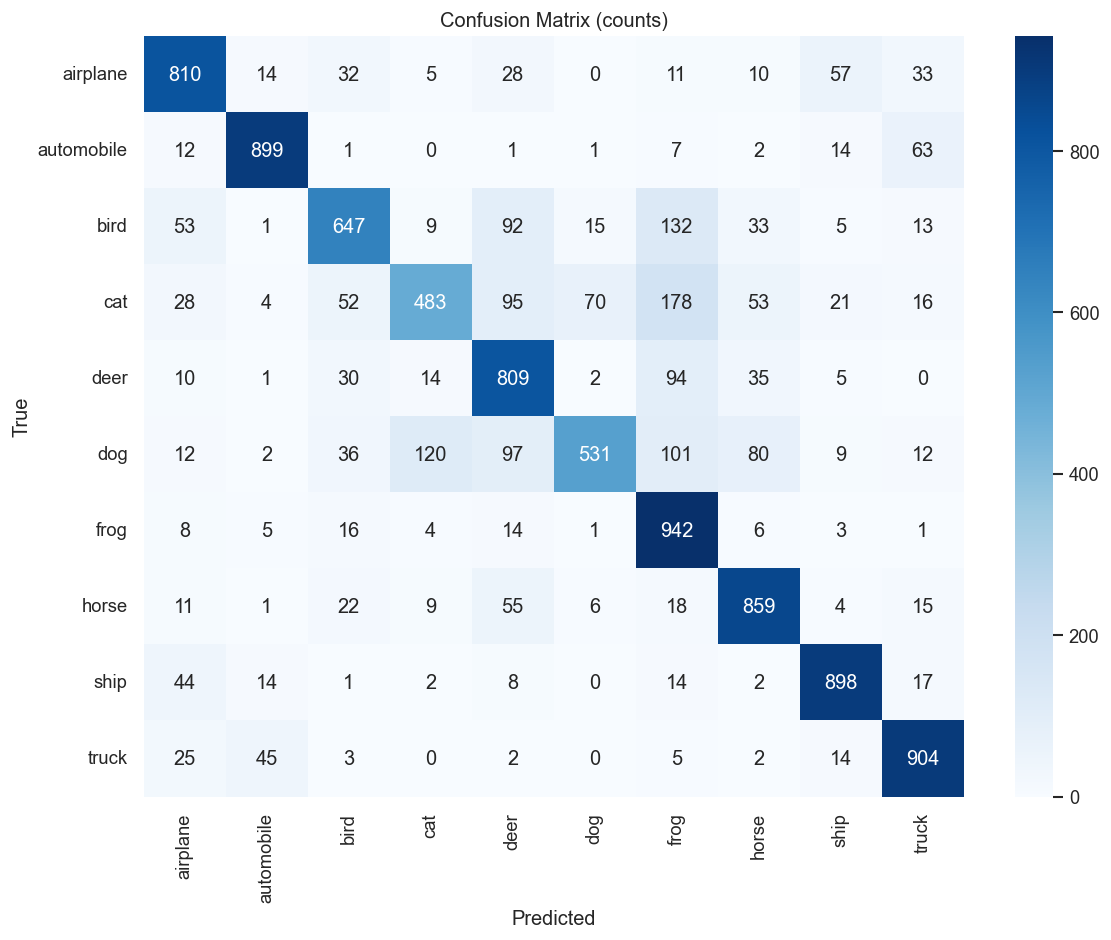

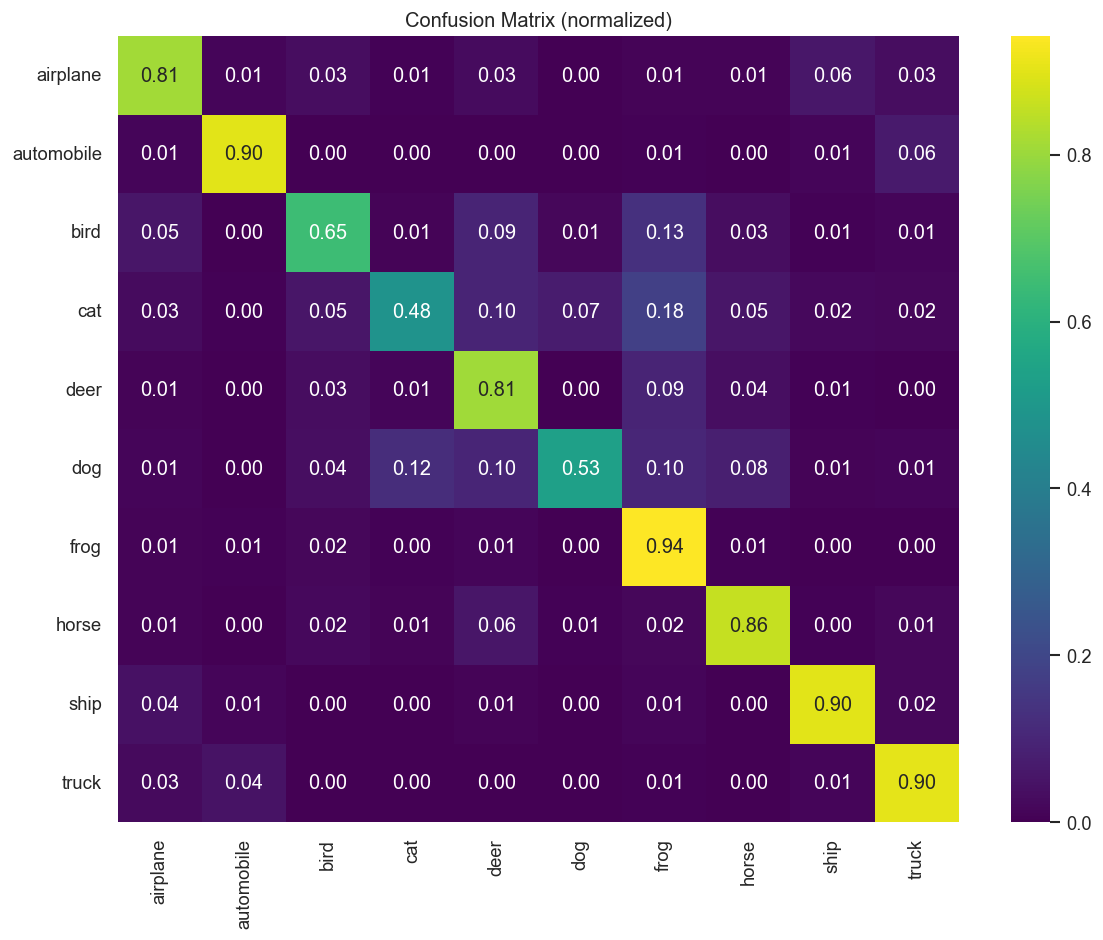

In [15]:
# Ensure model is loaded for evaluation
mdl_eval = load_latest_model("models/cifar10_model_latest.h5")
y_probs = mdl_eval.predict(X_test_p)
y_pred = np.argmax(y_probs, axis=1)
y_true = y_test.flatten()

acc = accuracy_score(y_true, y_pred)
prec_w = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec_w = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_w = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Weighted Precision: {prec_w:.4f}")
print(f"Weighted Recall: {rec_w:.4f}")
print(f"Weighted F1: {f1_w:.4f}")

# Save eval metrics
eval_metrics = {
    "accuracy": float(acc),
    "precision_weighted": float(prec_w),
    "recall_weighted": float(rec_w),
    "f1_weighted": float(f1_w),
    "model_used": latest_path,
    "timestamp": datetime.now().isoformat()
}
with open("logs/eval_metrics.json", "w") as f:
    json.dump(eval_metrics, f, indent=2)
print("Saved eval metrics to logs/eval_metrics.json")

# Classification report + confusion matrix
print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (counts)')
plt.tight_layout()
plt.savefig('logs/confusion_matrix_counts.png', dpi=150)
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (normalized)')
plt.tight_layout()
plt.savefig('logs/confusion_matrix_normalized.png', dpi=150)
plt.show()

## **9. Visualize sample predictions**
Displayed 20 random test images with predicted vs true labels.
Correct predictions show in green, incorrect in red.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16804\2995539804.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_lbl = class_names[int(y_test[idx])]


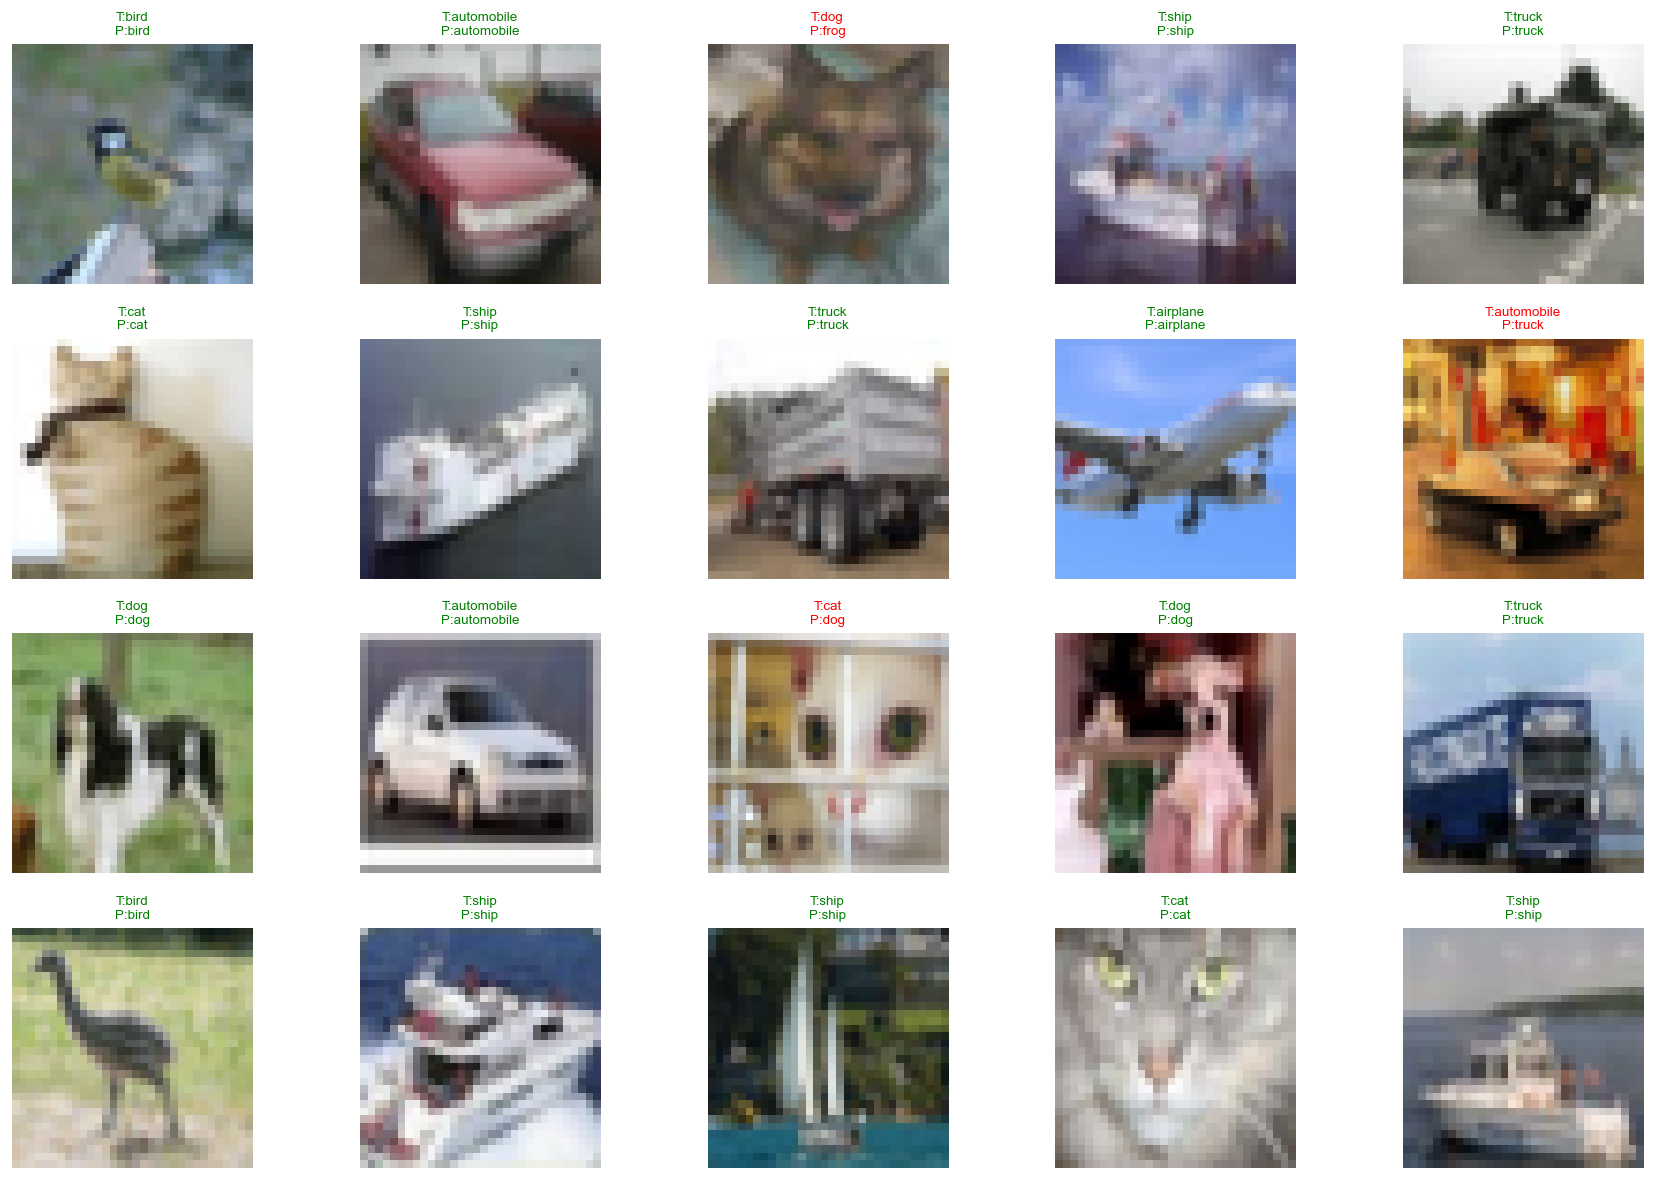

In [16]:
plt.figure(figsize=(15,10))
n = 20
idxs = np.random.choice(len(X_test), size=n, replace=False)
for i, idx in enumerate(idxs):
    plt.subplot(4,5,i+1)
    plt.imshow(X_test[idx])
    true_lbl = class_names[int(y_test[idx])]
    pred_lbl = class_names[int(y_pred[idx])]
    color = "green" if true_lbl == pred_lbl else "red"
    plt.title(f"T:{true_lbl}\nP:{pred_lbl}", color=color, fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.savefig('logs/sample_predictions.png', dpi=150)
plt.show()

## **10. Retraining helper — how it works**
This retrain helper:
1. Looks for labeled images under `data/retrain/<class_name_or_index>/`
2. Loads them, preprocesses, and continues training from `models/cifar10_model_latest.h5`
3. Backs up the current latest model before overwriting
4. Saves a timestamped retrained model and logs

This can be called from the notebook, or wired to an API endpoint `/retrain`.

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_from_retrain_dir(retrain_dir='data/retrain', target_size=(32,32)):
    Xr, yr = [], []
    if not os.path.exists(retrain_dir):
        return np.empty((0,)+target_size+(3,)), np.array([])
    for class_entry in sorted(os.listdir(retrain_dir)):
        class_path = os.path.join(retrain_dir, class_entry)
        if not os.path.isdir(class_path):
            continue
        # Resolve class index
        if class_entry.isdigit():
            class_idx = int(class_entry)
        else:
            try:
                class_idx = class_names.index(class_entry)
            except ValueError:
                print(f"[Warning] Unknown class folder '{class_entry}', skipping.")
                continue
        for fname in os.listdir(class_path):
            if not fname.lower().endswith(('.png','.jpg','.jpeg')):
                continue
            fpath = os.path.join(class_path, fname)
            img = load_img(fpath, target_size=target_size)
            arr = img_to_array(img)
            Xr.append(arr)
            yr.append(class_idx)
    Xr = np.array(Xr) if len(Xr)>0 else np.empty((0,)+target_size+(3,))
    yr = np.array(yr) if len(yr)>0 else np.array([])
    return Xr, yr

def retrain_from_directory(retrain_dir='data/retrain', epochs=3, batch_size=64, backup=True):
    Xr, yr = load_images_from_retrain_dir(retrain_dir)
    if len(Xr) == 0:
        print("No retrain data found in", retrain_dir)
        return None
    print(f"Found {len(Xr)} images for retraining.")
    Xr_p, yr_p = preprocess_arrays(Xr, yr)
    latest = "models/cifar10_model_latest.h5"
    if not os.path.exists(latest):
        raise FileNotFoundError("Latest model not found. Train first.")
    if backup:
        backup_path = f"models/cifar10_model_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
        shutil.copy2(latest, backup_path)
        print(f"Backed up latest model to {backup_path}")
    model = load_model(latest)
    cb = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
    ]
    history = model.fit(Xr_p, yr_p, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=cb, verbose=1)
    ts = datetime.now().strftime('%Y%m%d_%H%M%S')
    newpath = f"models/cifar10_model_retrained_{ts}.h5"
    model.save(newpath)
    model.save(latest)
    print(f"Retrained model saved to {newpath} and overwritten {latest}")
    retrain_log = {
        "timestamp": ts,
        "retrain_dir": retrain_dir,
        "new_model": newpath,
        "history": {k:[float(x) for x in v] for k,v in history.history.items()}
    }
    with open(f"logs/retrain_log_{ts}.json","w") as f:
        json.dump(retrain_log, f, indent=2)
    print("Retraining logs saved.")
    return retrain_log

### **How to test retraining manually**
1. Added new labeled images to `data/retrain/<class_name_or_index>/` (e.g., `data/retrain/cat/img1.png`)
2. Run:
   ```python
   retrain_info = retrain_from_directory('data/retrain', epochs=3)
   print(retrain_info)

In [21]:

---

### Cell 24 — CODE (Optional example retrain call — commented)
```python
# Example usage (uncomment when you have retrain images)
# result = retrain_from_directory('data/retrain', epochs=3)
# print(result)


SyntaxError: invalid syntax (1384269570.py, line 1)

## **11. Dataset insights**

**1. Class confusion (cats vs dogs, truck vs automobile)**  
   - These are visually similar in CIFAR-10; expect the model to confuse these. Show confusion matrix in report/video.

**2. Pixel intensity range**  
   - Most images use the full color intensity range; normalization is important to speed training.

**3. Effect of augmentation**  
   - Mild horizontal flips/rotations reduce overfitting and improve generalization for many classes; too much augmentation can hurt texture-based classes.